In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from src.plot_network import plot_topic_pairs_ntw

## Load data

Note that this time we have segmented text more and longer sequences have been splitted into multiple lines (maximum segment lenght is 80 tokens). Some info about the columns:
-  'Name': name of the topic
- 'cluster_name': name of the cluster (topics are a bit clustered)
- 'cluster_name_very_high': very high level clusters
- 'topic_reduce_outliers': topics where some -1 texts have been assigned to closest topics
- 'Name_red_outliers': name of the topic where outlier has been reduced

In [2]:
cols_keep=['heading', 'speaker', 'link_video', 'link_steno', 'index_pk',
       'index_snd', 'year', 'month', 'day', 'time', 'seconds_from_start',
       'video_link_wo_time', 'text_wo_punct', 'date', 'koosseis', 'fation',
       'ntoks', 'text_splitted', 'ntoks_splitted', 'doc_id', 'topic_id',
       'topic_prob', 'Name','Name_red_outliers']
df=pd.read_csv('data/interim/topics2022/stenos_cleaned_faction2022_topics.csv')[cols_keep]
df.shape

(465494, 24)

In [3]:
#normalize factions
df['fation']=df.fation.replace({'Fraktsiooni mittekuuluvad saadikud': 'Fraktsioonidesse mittekuulunud Riigikogu liikmed',
                               'Fraktsiooni mittekuuluvad Riigikogu liikmed':'Fraktsioonidesse mittekuulunud Riigikogu liikmed'})
df['fation']=np.where(pd.isnull(df.fation), 'no_faction', df.fation)

In [4]:
df_topics=pd.read_excel('data/interim/topics2022/topics_info2022_manual_review.xlsx')
df_topics.shape

(2107, 9)

## Keep only meaningful, not formal topics

In [5]:
df.columns

Index(['heading', 'speaker', 'link_video', 'link_steno', 'index_pk',
       'index_snd', 'year', 'month', 'day', 'time', 'seconds_from_start',
       'video_link_wo_time', 'text_wo_punct', 'date', 'koosseis', 'fation',
       'ntoks', 'text_splitted', 'ntoks_splitted', 'doc_id', 'topic_id',
       'topic_prob', 'Name', 'Name_red_outliers'],
      dtype='object')

In [6]:
df_topics.head()

,Topic,Count,Name,Representation,Representative_Docs,related2nature,manual_cluster,topic_cluster,topic_cluster_very_high
0,-1,227264,-1_ma_te_me_et,"['ma', 'te', 'me', 'et', 'aga', 'see', 'siin',...",['head ametikaaslased eesti keskerakonna frakt...,NaN,junk,-1_ma_te_me_et,-1_ma_te_me_et
1,0,5772,0_aeg_jaa_aitäh_midagi,"['aeg', 'jaa', 'aitäh', 'midagi', 'kuulda', 'v...","['aitäh rohkem küsimusi ei ole ma tänan', 'ait...",NaN,formaalsus,metsa_rmk_töökorra_kodu_riigimetsa,aastal_eurot_euroopa_aasta_kui
2,1,4061,1_perede_pere_lapse_laste,"['perede', 'pere', 'lapse', 'laste', 'lapsi', ...",['keskendunud ühiskonnagruppidele kes endaga h...,NaN,sisukas,lapse_perede_pere_laste_last,aastal_eurot_euroopa_aasta_kui
3,2,3780,2_metsa_rmk_riigimetsa_metsanduse,"['metsa', 'rmk', 'riigimetsa', 'metsanduse', '...",['eesti pinnast riigimetsa majandamise keskus ...,yes,sisukas,metsa_rmk_töökorra_kodu_riigimetsa,aastal_eurot_euroopa_aasta_kui
4,3,2735,3_maaelu_top_piima_põllumajanduse,"['maaelu', 'top', 'piima', 'põllumajanduse', '...",['ka seda ja mitte ainult nende 50 miljoni eur...,NaN,sisukas,maaelu_põllumajanduse_top_põllumehed_põllumeeste,aastal_eurot_euroopa_aasta_kui


In [7]:
topics_meaningful=df_topics[df_topics.manual_cluster=='sisukas'].Name.tolist()
len(topics_meaningful)

1159

In [8]:
topics_meaningful[:4]

['1_perede_pere_lapse_laste',
 '2_metsa_rmk_riigimetsa_metsanduse',
 '3_maaelu_top_piima_põllumajanduse',
 '4_euroopa_liidu_liitu_eesistumise']

In [9]:
df['topic4analysis']=np.where(df.Name_red_outliers.isin(topics_meaningful), df.Name_red_outliers, '-1')

## Environmental topics

In [10]:
topics_environment=df_topics[df_topics.related2nature=='yes'].Name.tolist()
len(topics_environment)
df['topic4analysis_env_bin']=np.where(df.topic4analysis.isin(topics_environment), 'env', 'other')

## Count of topics

<Axes: >

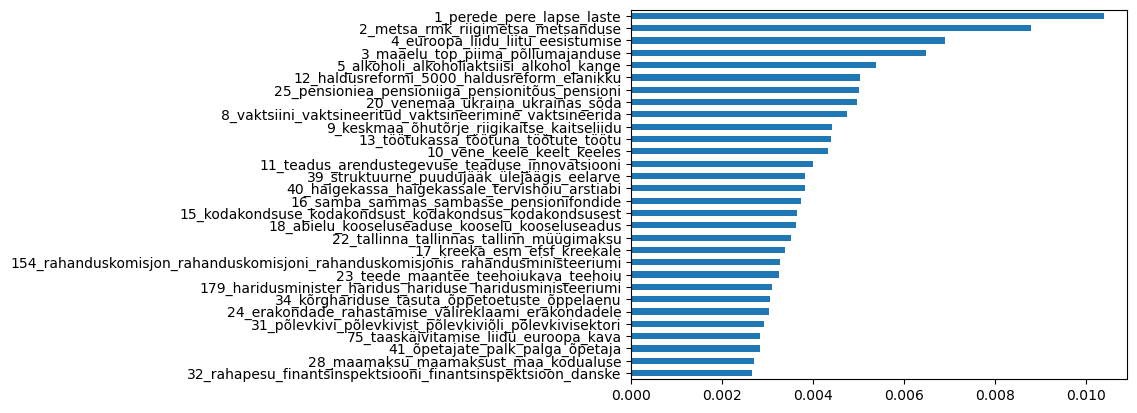

In [11]:
df.topic4analysis.value_counts(normalize=True).sort_values()[:-1].tail(30).plot(kind='barh')

## % of topics per year

In [12]:
# Step 1: Count occurrences of each topic per year
topic_counts = df.groupby(['year', 'topic4analysis']).size().reset_index(name='count')
# Step 2: Calculate the total occurrences per year
year_totals = df.groupby('year').size().reset_index(name='total_count')
# Step 3: Merge the counts and totals, then calculate percentages
df_long_perc = pd.merge(topic_counts, year_totals, on='year')
df_long_perc['percentage'] = (df_long_perc['count'] / df_long_perc['total_count']) * 100
df_long_perc.head()

,year,topic4analysis,count,total_count,percentage
0,2010,-1,17518,34072,51.414651
1,2010,1000_arveid_arvete_arvetele_arve,1,34072,0.002935
2,2010,1002_ravimite_ravimiameti_hinnakokkuleppe_amr,13,34072,0.038154
3,2010,1003_eleringi_võrgutasu_võrgutasude_elektriarvest,10,34072,0.029350
4,2010,1004_menetlusaeg_haldusasjade_tsiviilasjade_ts...,11,34072,0.032285


In [13]:
df_wide_perc=df_long_perc.pivot(index='year', columns='topic4analysis', values='percentage').T
df_wide_perc=df_wide_perc.fillna(0)
df_wide_perc.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
topic4analysis,,,,,,,,,,,,,,
-1,51.414651,52.112734,54.070299,53.942810,51.939635,50.540272,50.325880,50.006303,51.682300,51.894835,50.475641,55.295894,52.749340,53.080118
1000_arveid_arvete_arvetele_arve,0.002935,0.000000,0.000000,0.010342,0.006354,0.003554,0.027574,0.002521,0.000000,0.080182,0.000000,0.000000,0.003453,0.000000
1002_ravimite_ravimiameti_hinnakokkuleppe_amr,0.038154,0.000000,0.035149,0.015513,0.006354,0.007109,0.005014,0.045380,0.027231,0.021101,0.151996,0.000000,0.022444,0.010560
1003_eleringi_võrgutasu_võrgutasude_elektriarvest,0.029350,0.020693,0.066784,0.031025,0.028594,0.031990,0.042615,0.000000,0.006051,0.000000,0.002621,0.007679,0.025896,0.000000
1004_menetlusaeg_haldusasjade_tsiviilasjade_tsiviilasjades,0.032285,0.024831,0.028120,0.000000,0.019063,0.007109,0.005014,0.005042,0.012103,0.004220,0.000000,0.028156,0.010359,0.010560


2010


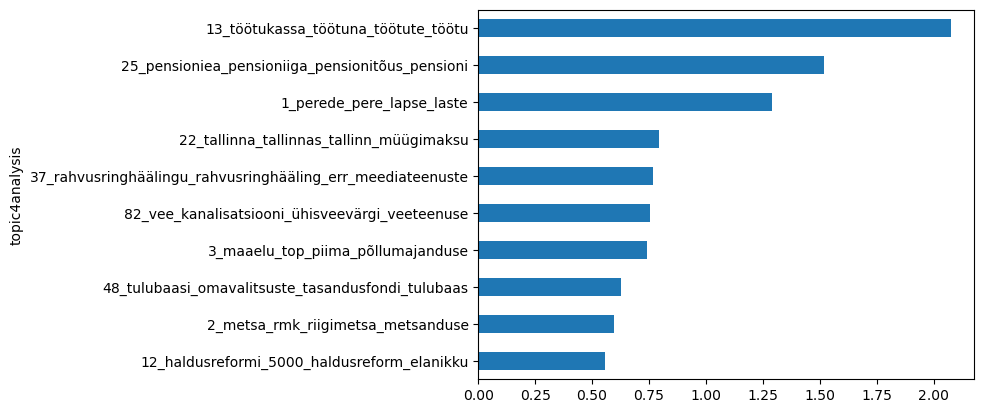

2011


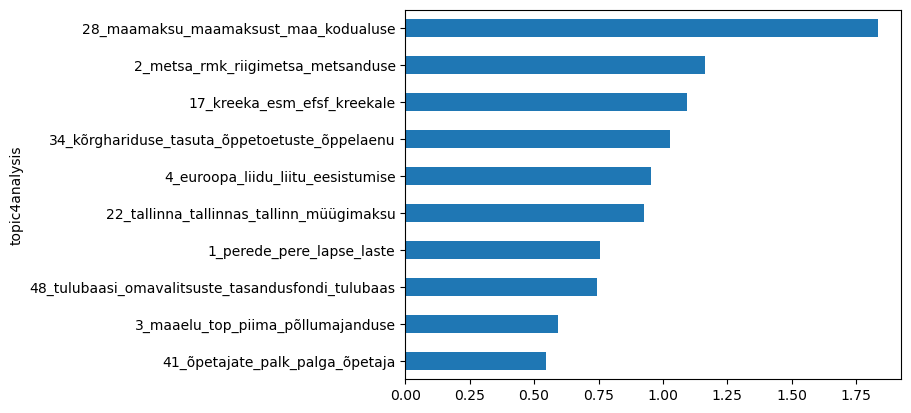

2012


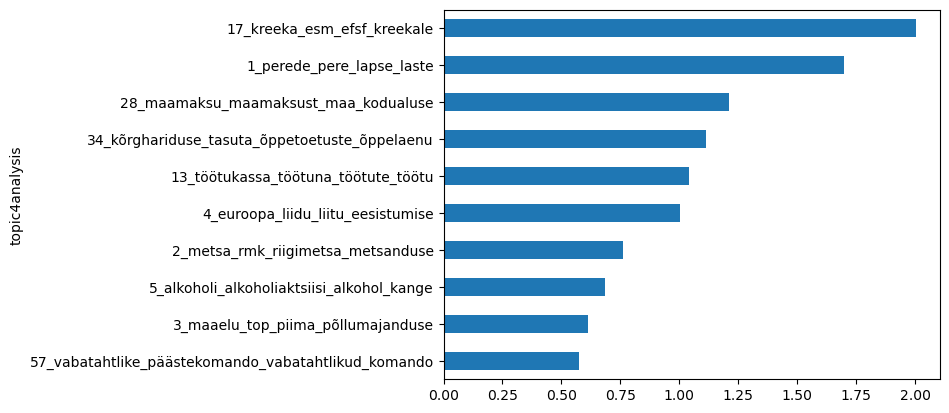

2013


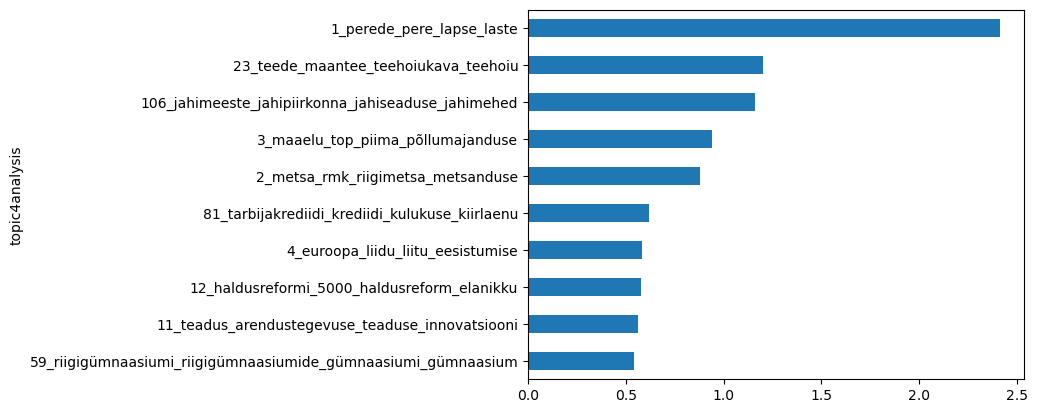

2014


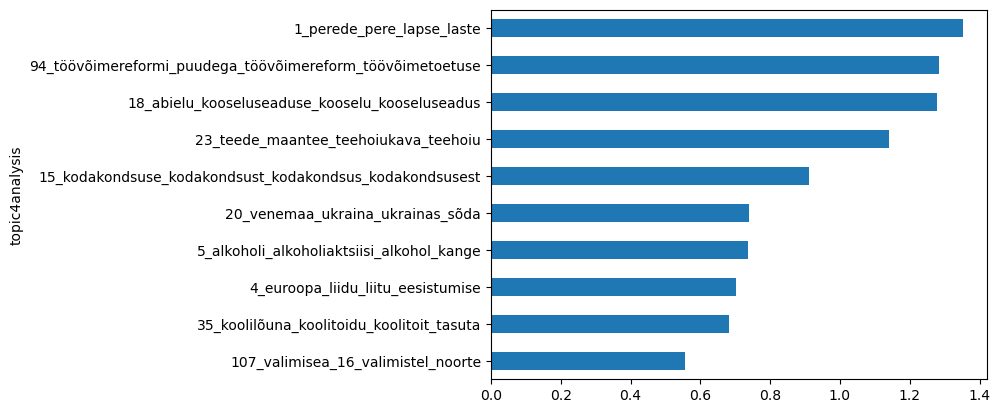

2015


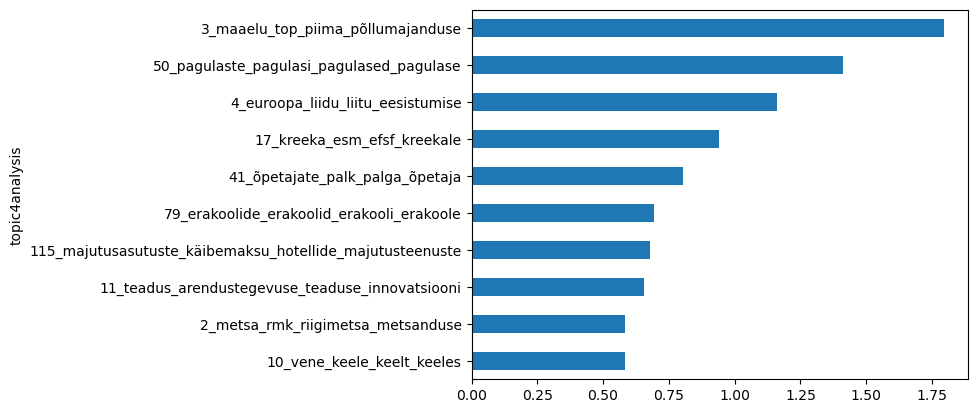

2016


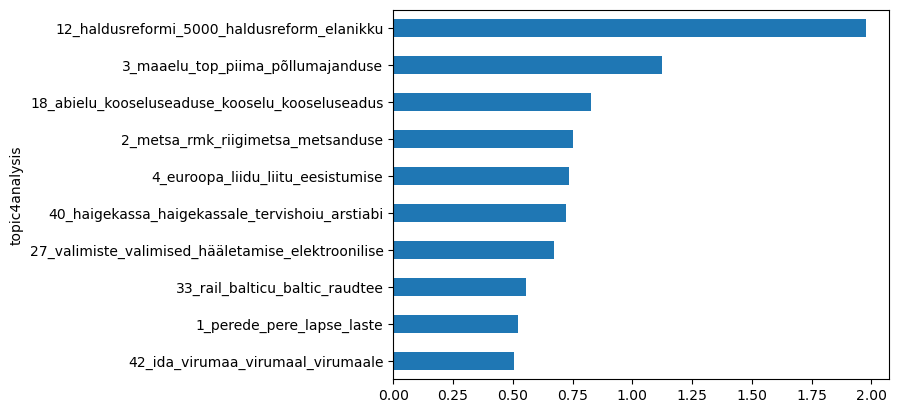

2017


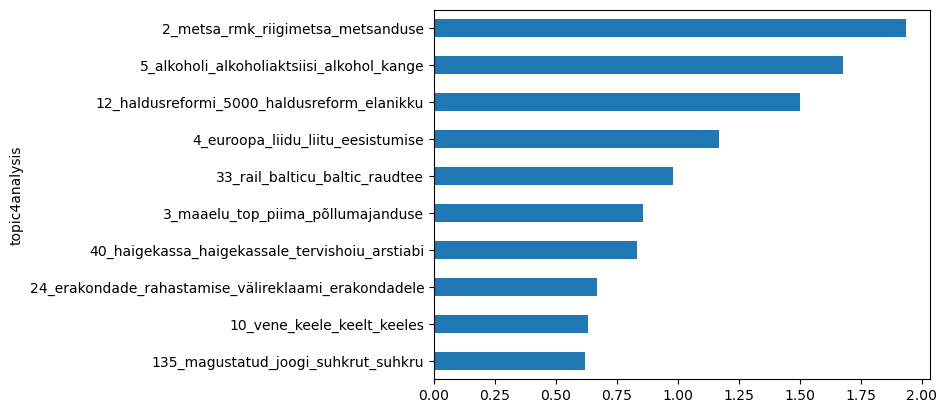

2018


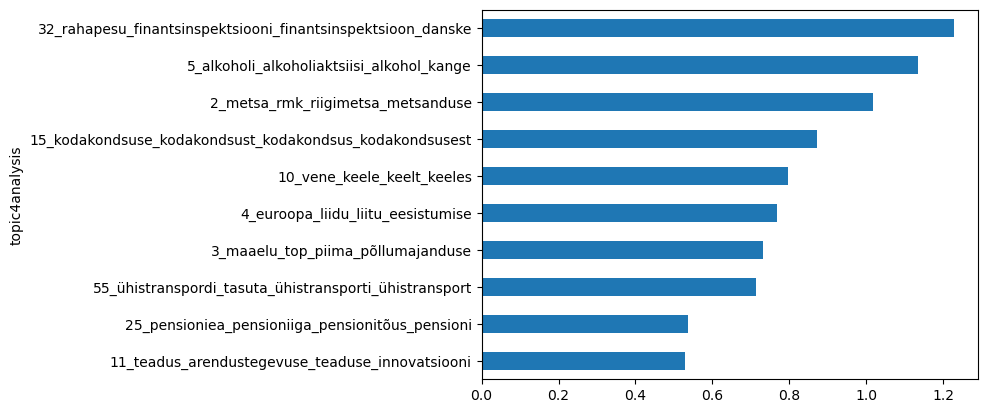

2019


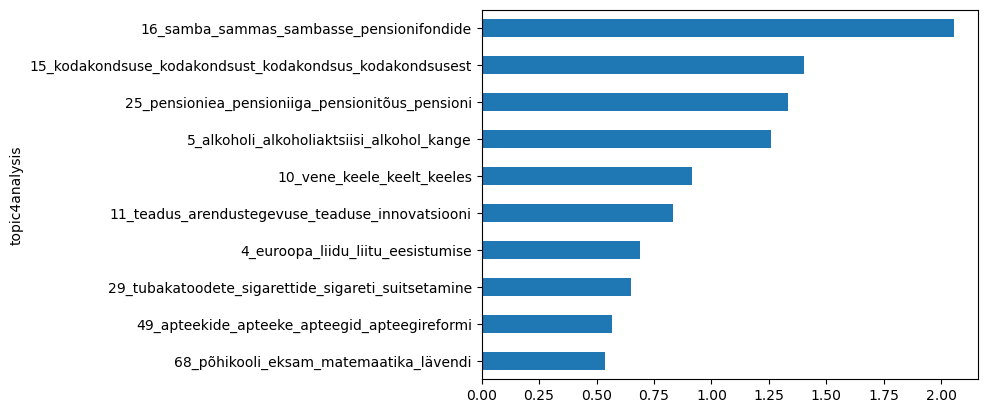

2020


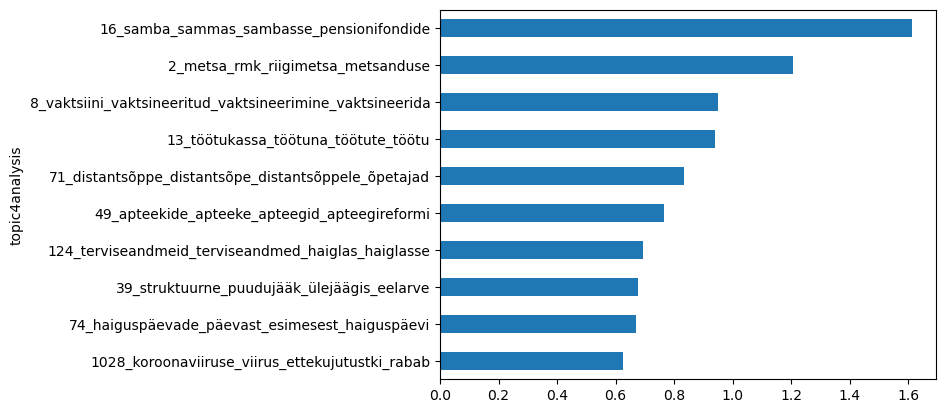

2021


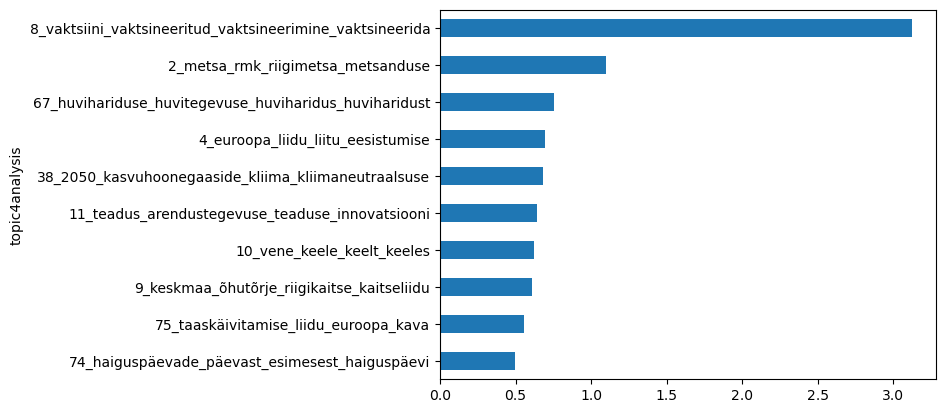

2022


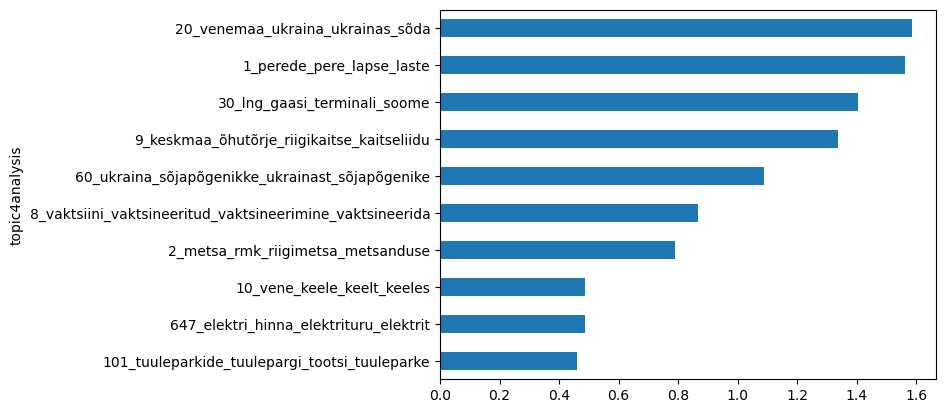

2023


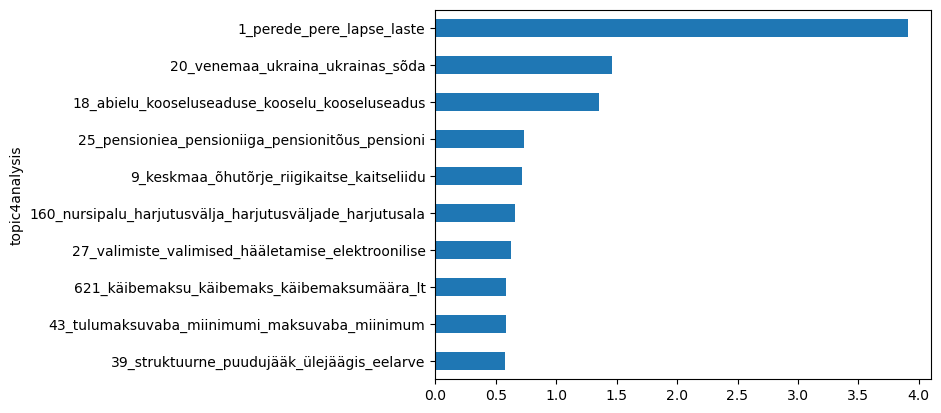

In [14]:
for year in df_long_perc.year.unique():
    print(year)
    df_wide_perc[year].sort_values(ascending=False)[1:].head(10).sort_values().plot(kind='barh')
    plt.show()

## Try to extract per index_pk topics - multiple topics per one discussion point

Topics per päevakorrapunkt

In [15]:
df.head()

,heading,speaker,link_video,link_steno,index_pk,index_snd,year,month,day,time,...,ntoks,text_splitted,ntoks_splitted,doc_id,topic_id,topic_prob,Name,Name_red_outliers,topic4analysis,topic4analysis_env_bin
0,10:00 Istungi rakendamine,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=0,https://stenogrammid.riigikogu.ee/201911191000,PKP-25040,SND-559399,2019,11,19,10:00,...,77,auväärt kolleegid auväärt riigikogu tere hommi...,77,0,273.0,0.652444,273_kohaloleku_kontroll_arupärimisi_töönädala,273_kohaloleku_kontroll_arupärimisi_töönädala,-1,other
1,1.\n 10:02 Eesti Keske...,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=125,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559400,2019,11,19,10:02,...,235,täna on meil päevakorras olulise tähtsusega ri...,80,1,1243.0,0.572646,1243_ettekanne_teostamisel_minutit_tegevusest,1243_ettekanne_teostamisel_minutit_tegevusest,-1,other
2,1.\n 10:02 Eesti Keske...,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=125,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559400,2019,11,19,10:02,...,235,kuni 20 minutit riigikogu liige võib esitada e...,80,2,207.0,0.850651,207_ettekanne_sõnavõttudega_minutit_vastused,207_ettekanne_sõnavõttudega_minutit_vastused,-1,other
3,1.\n 10:02 Eesti Keske...,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=125,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559400,2019,11,19,10:02,...,235,pikendada istungi aega kuni päevakorrapunkti a...,75,3,139.0,0.818905,139_ammendumiseni_pikendada_kauem_kella,139_ammendumiseni_pikendada_kauem_kella,-1,other
4,1.\n 10:02 Eesti Keske...,Kersti Sarapuu,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=238,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559401,2019,11,19,10:02,...,1575,lugupeetud istungi juhataja head kolleegid ja ...,80,4,-1.0,0.000000,-1_ma_te_me_et,1461_maksude_maksud_maksudega_mängita,1461_maksude_maksud_maksudega_mängita,other


In [16]:
df.index_pk.nunique()

11171

In [17]:
df.index_snd.nunique()

241366

In [18]:
#check that index_pk is unique over the time
df['time_index_pk']=df.year.astype(str)+'_'+df.month.astype(str)+'_'+df.day.astype(str)+'_'+df.index_pk
df.index_pk.nunique()

11171

#### Calculate per index_pk unique topics

In [19]:
topic_occurences=df[(df.topic4analysis!='-1')&(~pd.isnull(df.topic4analysis))].topic4analysis.tolist()
len(topic_occurences)

223216

In [20]:
topic_pairs = []
for topics in df[(df.topic4analysis!='-1')].groupby('index_pk').topic4analysis.unique():
    topics_ = list(set(topics))
    for i in range(len(topics_)-1):
        for j in range(i+1, len(topics_)):
            #keep sorting same always
            topic_pair=list(set([topics_[i], topics_[j]]))
            topic_i=topic_pair[0]
            topic_j=topic_pair[1]
            topic_pairs.append([topic_j, topic_i])

In [21]:
df_topic_pairs = pd.DataFrame(data = topic_pairs, columns=['topic1', 'topic2'])
df_topic_pairs_count = df_topic_pairs.groupby(['topic1', 'topic2']).size()
df_topic_pairs_count = df_topic_pairs_count.sort_values().reset_index()
df_topic_pairs_count.columns=['topic1', 'topic2', 'pair_count']
df_topic_pairs_count.shape

(189389, 3)

In [22]:
df_topic_pairs_count.sort_values('pair_count',ascending=False)

,topic1,topic2,pair_count
189388,295_eelarve_riigieelarve_eelarvet_eelarvega,39_struktuurne_puudujääk_ülejäägis_eelarve,222
189387,309_riigieelarve_eelarve_seletuskiri_eelarvest...,295_eelarve_riigieelarve_eelarvet_eelarvega,175
189386,4_euroopa_liidu_liitu_eesistumise,75_taaskäivitamise_liidu_euroopa_kava,175
189385,1_perede_pere_lapse_laste,25_pensioniea_pensioniiga_pensionitõus_pensioni,174
189384,39_struktuurne_puudujääk_ülejäägis_eelarve,75_taaskäivitamise_liidu_euroopa_kava,166
...,...,...,...
54368,525_lisaeelarve_lisaeelarvet_kriisiga_kriis,1483_kooseluseaduse_irl_paarkonna_kooseluseadus,1
54369,525_lisaeelarve_lisaeelarvet_kriisiga_kriis,1477_julgeolekuasutuste_luurekeskuse_kaitseväe...,1
54370,525_lisaeelarve_lisaeelarvet_kriisiga_kriis,144_täitmisel_kohustuste_rahvusvaheliste_piken...,1
54371,525_lisaeelarve_lisaeelarvet_kriisiga_kriis,2038_vaktsiinikahjude_vastutuskindlustust_pats...,1


In [23]:
df_topic_pairs_count.sort_values('pair_count',ascending=False).head()

,topic1,topic2,pair_count
189388,295_eelarve_riigieelarve_eelarvet_eelarvega,39_struktuurne_puudujääk_ülejäägis_eelarve,222
189387,309_riigieelarve_eelarve_seletuskiri_eelarvest...,295_eelarve_riigieelarve_eelarvet_eelarvega,175
189386,4_euroopa_liidu_liitu_eesistumise,75_taaskäivitamise_liidu_euroopa_kava,175
189385,1_perede_pere_lapse_laste,25_pensioniea_pensioniiga_pensionitõus_pensioni,174
189384,39_struktuurne_puudujääk_ülejäägis_eelarve,75_taaskäivitamise_liidu_euroopa_kava,166


## Plot topics network

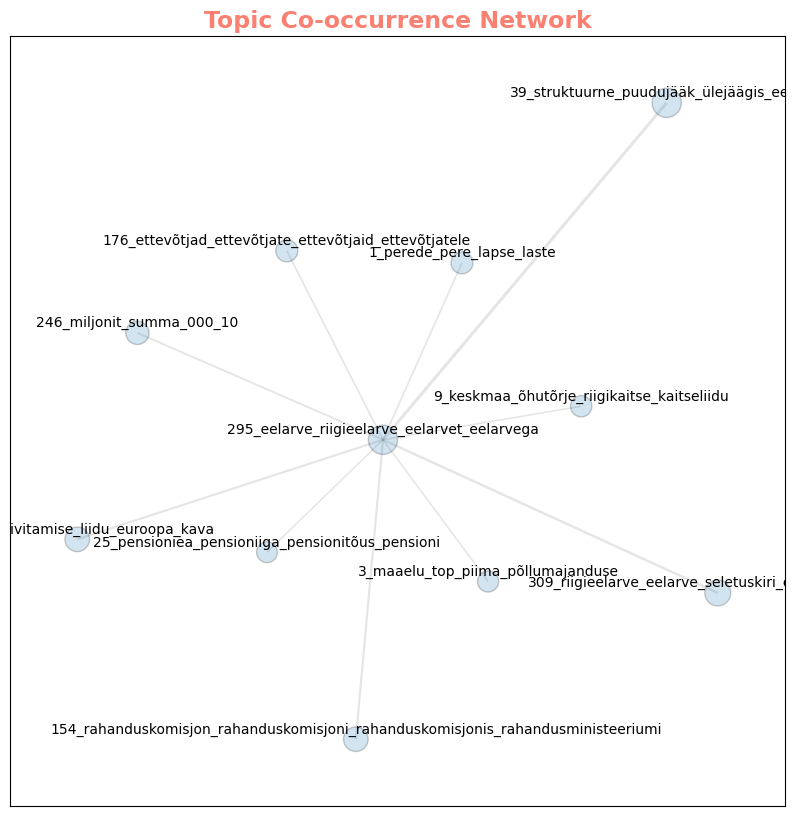

In [24]:
topic='295_eelarve_riigieelarve_eelarvet_eelarvega'
plot_topic_pairs_ntw(df_topic_pairs_count[(df_topic_pairs_count.topic1==topic)|(df_topic_pairs_count.topic2==topic)].tail(10),
                     weight_div_fac=100, node_size_div_fac=0.5, alpha=0.2)

In [25]:
df_topic_pairs_count[(df_topic_pairs_count.topic1==topic)|(df_topic_pairs_count.topic2==topic)].tail(10)

,topic1,topic2,pair_count
189312,295_eelarve_riigieelarve_eelarvet_eelarvega,25_pensioniea_pensioniiga_pensionitõus_pensioni,112
189316,295_eelarve_riigieelarve_eelarvet_eelarvega,3_maaelu_top_piima_põllumajanduse,115
189326,295_eelarve_riigieelarve_eelarvet_eelarvega,9_keskmaa_õhutõrje_riigikaitse_kaitseliidu,118
189334,1_perede_pere_lapse_laste,295_eelarve_riigieelarve_eelarvet_eelarvega,124
189346,176_ettevõtjad_ettevõtjate_ettevõtjaid_ettevõt...,295_eelarve_riigieelarve_eelarvet_eelarvega,126
189365,295_eelarve_riigieelarve_eelarvet_eelarvega,246_miljonit_summa_000_10,140
189379,295_eelarve_riigieelarve_eelarvet_eelarvega,75_taaskäivitamise_liidu_euroopa_kava,157
189380,295_eelarve_riigieelarve_eelarvet_eelarvega,154_rahanduskomisjon_rahanduskomisjoni_rahandu...,157
189387,309_riigieelarve_eelarve_seletuskiri_eelarvest...,295_eelarve_riigieelarve_eelarvet_eelarvega,175
189388,295_eelarve_riigieelarve_eelarvet_eelarvega,39_struktuurne_puudujääk_ülejäägis_eelarve,222


## Calculate PMI and NPMI


In [26]:
df_all_top_count=pd.DataFrame(df.groupby(['topic4analysis']).size())
df_all_top_count.columns=['count']

In [27]:
df_all_top_count.head()

,count
topic4analysis,
-1,242278
1000_arveid_arvete_arvetele_arve,39
1002_ravimite_ravimiameti_hinnakokkuleppe_amr,138
1003_eleringi_võrgutasu_võrgutasude_elektriarvest,96
1004_menetlusaeg_haldusasjade_tsiviilasjade_tsiviilasjades,62


In [28]:
df_topic_pairs_count.head()

,topic1,topic2,pair_count
0,1000_arveid_arvete_arvetele_arve,1024_turismisektor_turismisektori_turismisekto...,1
1,238_panga_nõukogu_laar_laari,1794_tasandusfondi_tulumaksuprotsendi_tasandus...,1
2,238_panga_nõukogu_laar_laari,1775_eestlaste_mustad_eestlase_taasleidmiseni,1
3,238_panga_nõukogu_laar_laari,174_kiriku_kirik_kirikule_kirikutele,1
4,238_panga_nõukogu_laar_laari,1686_psühholoogilist_indeksi_taotlusmehhanismi...,1


In [29]:
def pairs2pmi(df_topic_pairs, df_all_top_count, df_all_group_count=None, group1_name='topic',
             group2_name=None, pair_key_col1='topic1', pair_key_col2='topic2'):
    """takes df_topic_pairs as input and calculates necessary pmi, npmi measures. If df_all_group_count
    is None calcluates NPMI between topic pairs. If it is not None, calclutes topic-other thing pair NPMI.
    This assumes df_topic_pairs has column which mathces keys in df_all_group_count columns
    """
    
    all_topic_count=df_all_top_count['count'].sum()
    df_topic_pairs['p_pair']=df_topic_pairs.pair_count/all_topic_count
    topic_count=df_all_top_count.copy()
    
    if df_all_group_count is None:
        group1_name_=f'{group1_name}1'
        group2_name_=f'{group1_name}2'
        group_count=df_all_top_count.copy()
    else:
        group_count=df_all_group_count.copy()
        group1_name_=f'{group1_name}'
        group2_name_=f'{group2_name}'
    topic_count.columns=[f'count_{group1_name_}']
    group_count.columns=[f'count_{group2_name_}']
    
    df_topic_pairs=pd.merge(df_topic_pairs, topic_count, left_on=pair_key_col1, right_index=True, how='left')
    df_topic_pairs=pd.merge(df_topic_pairs, group_count, left_on=pair_key_col2, right_index=True, how='left')
    df_topic_pairs[f'p_{group1_name_}']=df_topic_pairs[f'count_{group1_name_}']/all_topic_count
     #all count is same so can reuse all_topic_count
    df_topic_pairs[f'p_{group2_name_}']=df_topic_pairs[f'count_{group2_name_}']/all_topic_count
    df_topic_pairs['pmi']=np.log2(df_topic_pairs.p_pair/(df_topic_pairs[f'p_{group1_name_}']*df_topic_pairs[f'p_{group2_name_}']))
    df_topic_pairs['npmi']=df_topic_pairs.pmi/(-np.log2(df_topic_pairs.p_pair)) 
    return df_topic_pairs

In [30]:
# pairs2pmi(df_topic_pairs_count, len(topic_pairs), df_all_top_count)

In [31]:
# df_topic_pairs_count=topic_pairs2pmi(df_topic_pairs_count, df_all_top_count)
df_topic_pairs_count=pairs2pmi(df_topic_pairs_count, df_all_top_count)

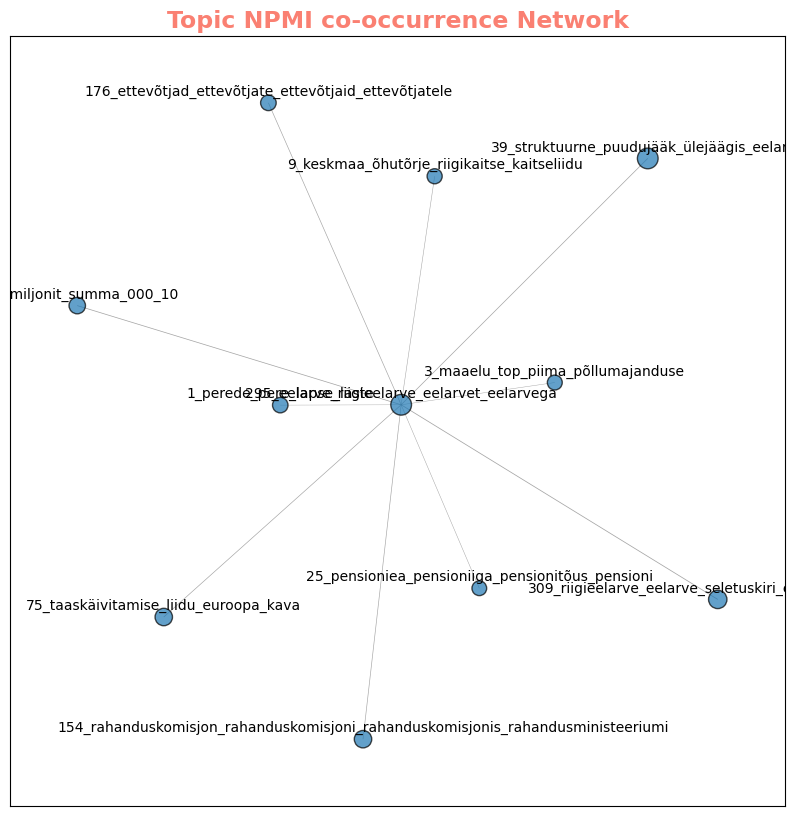

In [32]:
topic='295_eelarve_riigieelarve_eelarvet_eelarvega'
plot_topic_pairs_ntw(df_topic_pairs_count[(df_topic_pairs_count.topic1==topic)|(df_topic_pairs_count.topic2==topic)].tail(10),
                     title='Topic NPMI co-occurrence Network',
                     weight_div_fac=1, weight_col='npmi')

## Save

In [33]:
df_topic_pairs_count.to_excel('data/interim/topics2022/topic_pairs_pmi.xlsx', index=False)

## Topic speaker pairs PMI and NPMI

In [34]:
def calc_topic_other_pairs(df, topic_col='topic4analysis', other_col='speaker'):
    """calculate co-occurence of topic and other element pairs"""
    topic_pairs = []
    for index_pk_ in df['index_pk'].unique():
        df_=df[df.index_pk==index_pk_]

        topics_ = list(set(df_[topic_col].tolist()))
        others_=list(set(df_[other_col].tolist()))
        for i in range(len(topics_)):
            for j in range(len(others_)):
                #keep sorting same always
                topic_pair=[others_[j], topics_[i]]
                topic_pairs.append(topic_pair)
                
    df_topic_pairs = pd.DataFrame(data = topic_pairs, columns=[other_col, 'topic'])
    df_topic_pairs_count = df_topic_pairs.groupby([other_col, 'topic']).size()
    df_topic_pairs_count = df_topic_pairs_count.sort_values().reset_index()
    df_topic_pairs_count.columns=[other_col, 'topic', 'pair_count']
    return df_topic_pairs_count

In [35]:
df_all_speakers_count=pd.DataFrame(df.groupby(['speaker']).size())
df_all_speakers_count.columns=['count']

In [36]:
df_topic_speaker_pairs_count=calc_topic_other_pairs(df)

In [37]:
df_topic_speaker_pairs_count[df_topic_speaker_pairs_count.topic!='-1'].sort_values('pair_count', ascending=False).head()

,speaker,topic,pair_count
212925,Peeter Ernits,4_euroopa_liidu_liitu_eesistumise,293
212899,Peeter Ernits,1087_käikude_valgustus_vähimatki_käike,229
212897,Esimees Eiki Nestor,4_euroopa_liidu_liitu_eesistumise,226
212895,Peeter Ernits,2_metsa_rmk_riigimetsa_metsanduse,219
212894,Aivar Sõerd,154_rahanduskomisjon_rahanduskomisjoni_rahandu...,215


In [38]:
df_topic_speaker_pairs_count.head()

,speaker,topic,pair_count
0,<span>Aseesimees </span>Laine Randjärv,-1,1
1,Helmut Hallemaa,308_raseduse_alaealise_alaealine_katkestamise,1
2,Margus Hanson,428_tarbijakaitse_tehnilise_järelevalve_tarbij...,1
3,Margus Hanson,433_riigikaitseõpetus_riigikaitseõpetuse_riigi...,1
4,Margus Hanson,434_riigikohtu_pikamäe_kõve_villu,1


In [39]:
df_topic_speaker_pairs_count=pairs2pmi(df_topic_speaker_pairs_count, df_all_top_count, df_all_speakers_count,
                                group1_name='topic',
                                group2_name='speaker',
                                pair_key_col1='topic',
                                pair_key_col2='speaker')

In [40]:
df_topic_speaker_pairs_count.sort_values('npmi', ascending=False).head(20)

,speaker,topic,pair_count,p_pair,count_topic,count_speaker,p_topic,p_speaker,pmi,npmi
56115,Reformierakonna fraktsioon,2014_kitarri_laulab_mängib_kop,1,0.000002,11,1,0.000024,0.000002,15.368971,0.816265
46690,Riigikogu juhatus,2014_kitarri_laulab_mängib_kop,1,0.000002,11,1,0.000024,0.000002,15.368971,0.816265
61983,Riigihalduse minister Anneli Ott,1542_ametivande_kuulame_otsusega_järgnevalt,1,0.000002,18,1,0.000039,0.000002,14.658478,0.778530
50918,Aseeesimees Siim Kallas,1966_süüteoennetuse_uimastiennetuse_ennetusnõu...,1,0.000002,18,1,0.000039,0.000002,14.658478,0.778530
31436,Keskkonnaminister Siim Valmar Kiisler,1542_ametivande_kuulame_otsusega_järgnevalt,1,0.000002,18,1,0.000039,0.000002,14.658478,0.778530
24098,Tanel Tein,1682_pigi_kaup_autode_numbrimärki,1,0.000002,19,1,0.000041,0.000002,14.580476,0.774387
24127,Tanel Tein,2078_balti_leedu_leedus_korrakaitsekomisjon,1,0.000002,21,1,0.000045,0.000002,14.436086,0.766719
194648,Väliskaubandus- ja infotehnoloogiaminister Ker...,1536_infotehnoloogiaminister_väliskaubandus_ki...,14,0.000030,19,120,0.000041,0.000258,11.480940,0.764323
32962,Keskerakonna fraktsioon,2014_kitarri_laulab_mängib_kop,1,0.000002,11,2,0.000024,0.000004,14.368971,0.763154
3916,Sotsiaaldemokraatliku Erakonna fraktsioon,2014_kitarri_laulab_mängib_kop,1,0.000002,11,2,0.000024,0.000004,14.368971,0.763154


In [41]:
df_topic_speaker_pairs_count.to_excel('data/interim/topics2022/topic_speaker_pairs_pmi.xlsx', index=False)

## Topic faction PMI and NPMI

In [42]:
df_all_faction_count=pd.DataFrame(df.groupby(['fation']).size())
df_all_faction_count.columns=['count']

In [43]:
df_topic_faction_pairs_count=calc_topic_other_pairs(df, other_col='fation')

In [44]:
df_topic_faction_pairs_count[df_topic_faction_pairs_count.topic!='-1'].sort_values('pair_count', ascending=False).head()

,fation,topic,pair_count
11421,no_faction,4_euroopa_liidu_liitu_eesistumise,872
11420,no_faction,154_rahanduskomisjon_rahanduskomisjoni_rahandu...,759
11419,no_faction,2_metsa_rmk_riigimetsa_metsanduse,717
11418,no_faction,1_perede_pere_lapse_laste,714
11417,no_faction,1087_käikude_valgustus_vähimatki_käike,681


In [45]:
df_topic_faction_pairs_count=pairs2pmi(df_topic_faction_pairs_count, df_all_top_count, df_all_faction_count,
                                      group1_name='topic', group2_name='fation', pair_key_col2='fation',
                                       pair_key_col1='topic')

In [46]:
df_topic_faction_pairs_count.sort_values('npmi', ascending=False).head(20)

,fation,topic,pair_count,p_pair,count_topic,count_fation,p_topic,p_fation,pmi,npmi
2193,Eesti 200 fraktsioon,1585_agressioonikuriteo_agressiooniakti_agress...,3,0.000006,29,295,0.000062,0.000634,7.350813,0.426296
4078,Eesti 200 fraktsioon,1737_reformierakond_vale_dogma_ideoloogiast,6,0.000013,83,295,0.000178,0.000634,6.833755,0.420709
2201,Eesti 200 fraktsioon,1473_kardad_impeeriume_lõppes_võitleme,3,0.000006,33,295,0.000071,0.000634,7.164400,0.415486
6927,Eestimaa Rahvaliidu fraktsioon,1951_tööhõiveküsimuste_jagusaamise_korporatiiv...,17,0.000037,113,1050,0.000243,0.002256,6.059513,0.411067
11256,Eesti Vabaerakonna fraktsioon,440_lugupeetav_lugupeetavad_eesistuja_vabaerak...,239,0.000513,442,11268,0.000950,0.024207,4.481423,0.410104
3715,Eestimaa Rahvaliidu fraktsioon,1779_lund_erimärgistatud_põllult_paagis,6,0.000013,30,1050,0.000064,0.002256,6.470301,0.398333
1386,Eesti 200 fraktsioon,1718_talibanlike_vasika_ilmale_muretsemisest,2,0.000004,24,295,0.000052,0.000634,7.038869,0.394812
4404,Eesti 200 fraktsioon,1453_vabandate_kaja_valetanud_kallas,7,0.000015,147,295,0.000316,0.000634,6.231514,0.388958
2912,Eesti 200 fraktsioon,1265_ebavõrdsus_ebavõrdsuse_ebavõrdsust_patust,4,0.000009,72,295,0.000155,0.000634,6.453907,0.383513
1523,Eesti 200 fraktsioon,1451_suunalise_äritegevuse_abikaasa_äritegevust,2,0.000004,28,295,0.000060,0.000634,6.816477,0.382338


In [47]:
df_topic_faction_pairs_count.to_excel('data/interim/topics2022/topic_faction_pairs_pmi.xlsx', index=False)

## Faction PMI and NPMI per year for environment topics

In [48]:
def npmi_per_groups(df, group_col='year', speaker_col='fation', topic_col='topic4analysis'):
    df_pairs_all=pd.DataFrame()
    for value in df[group_col].unique():
        df_=df[df[group_col]==value]
        df_speaker_count_=pd.DataFrame(df_.groupby([speaker_col]).size())
        df_speaker_count_.columns=['count']
        df_top_count_=pd.DataFrame(df_.groupby([topic_col]).size())
        df_top_count_.columns=['count']
        print(value)
#         df_pairs_=npmi_one_group(df_, speaker_col=speaker_col, topic_col=topic_col)
        df_pairs_=calc_topic_other_pairs(df_, topic_col=topic_col, other_col=speaker_col)
        df_pairs_=pairs2pmi(df_pairs_, df_top_count_, df_speaker_count_, group2_name=speaker_col,
                           pair_key_col1='topic',
                            pair_key_col2=speaker_col)
        
        df_pairs_['year']=value
        df_pairs_all=pd.concat([df_pairs_all, df_pairs_])
    return df_pairs_all

In [49]:
df_npmi_faction_env_bin=npmi_per_groups(df, topic_col='topic4analysis_env_bin')

2019
2021
2010
2015
2012
2017
2020
2011
2013
2016
2014
2018
2022
2023


In [50]:
df_npmi_faction_env_bin.head()

,fation,topic,pair_count,p_pair,count_topic,count_fation,p_topic,p_fation,pmi,npmi,year
0,Eesti Vabaerakonna fraktsioon,env,9,0.000380,444,454,0.018737,0.019159,0.081317,0.007157,2019
1,Fraktsioonidesse mittekuulunud Riigikogu liikmed,env,18,0.000760,444,464,0.018737,0.019581,1.049884,0.101316,2019
2,Eesti Keskerakonna fraktsioon,env,29,0.001224,444,1113,0.018737,0.046970,0.475683,0.049169,2019
3,Eesti Konservatiivse Rahvaerakonna fraktsioon,env,31,0.001308,444,1100,0.018737,0.046421,0.588849,0.061478,2019
4,Isamaa fraktsioon,env,33,0.001393,444,1574,0.018737,0.066425,0.162114,0.017086,2019


In [51]:
df_npmi_faction_env_bin.head()

,fation,topic,pair_count,p_pair,count_topic,count_fation,p_topic,p_fation,pmi,npmi,year
0,Eesti Vabaerakonna fraktsioon,env,9,0.000380,444,454,0.018737,0.019159,0.081317,0.007157,2019
1,Fraktsioonidesse mittekuulunud Riigikogu liikmed,env,18,0.000760,444,464,0.018737,0.019581,1.049884,0.101316,2019
2,Eesti Keskerakonna fraktsioon,env,29,0.001224,444,1113,0.018737,0.046970,0.475683,0.049169,2019
3,Eesti Konservatiivse Rahvaerakonna fraktsioon,env,31,0.001308,444,1100,0.018737,0.046421,0.588849,0.061478,2019
4,Isamaa fraktsioon,env,33,0.001393,444,1574,0.018737,0.066425,0.162114,0.017086,2019


## Save

In [52]:
df_npmi_faction_env_bin.to_excel('data/interim/topics2022/env_topic_faction_pairs_pmi.xlsx', index=False)

## Plot faction vs env topic NPMI

% of topics that are environment topics for each faction. NPMI looks like to be too unreliable for small numbers

<Axes: xlabel='year'>

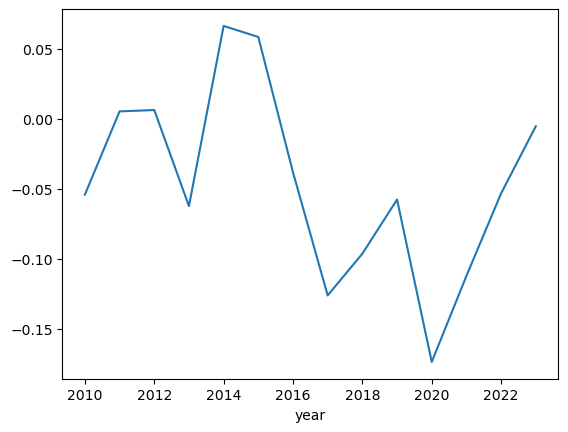

In [53]:
df_npmi_faction_env_bin[(df_npmi_faction_env_bin.topic=='env')&(df_npmi_faction_env_bin.fation=='Eesti Reformierakonna fraktsioon')]\
.sort_values('year').set_index('year')['npmi'].plot()

<Axes: xlabel='year'>

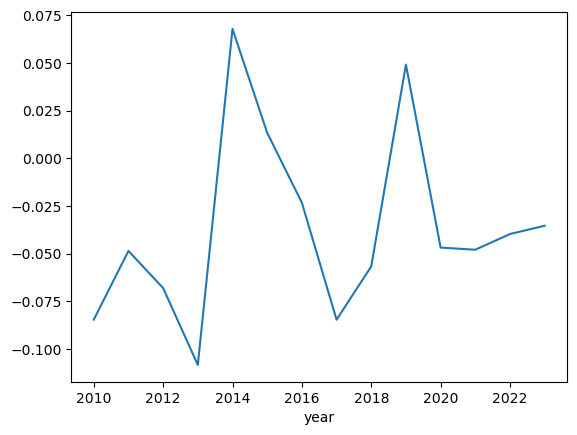

In [54]:
df_npmi_faction_env_bin[(df_npmi_faction_env_bin.topic=='env')&(df_npmi_faction_env_bin.fation=='Eesti Keskerakonna fraktsioon')]\
.sort_values('year').set_index('year')['npmi'].plot()

<Axes: xlabel='year'>

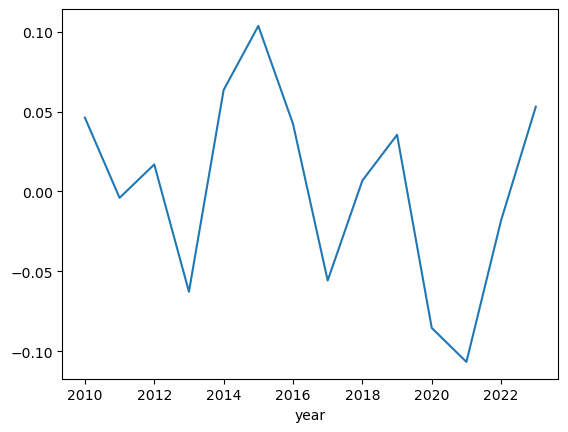

In [55]:
df_npmi_faction_env_bin[(df_npmi_faction_env_bin.topic=='env')&(df_npmi_faction_env_bin.fation=='Sotsiaaldemokraatliku Erakonna fraktsioon')]\
.sort_values('year').set_index('year')['npmi'].plot()

<Axes: xlabel='year'>

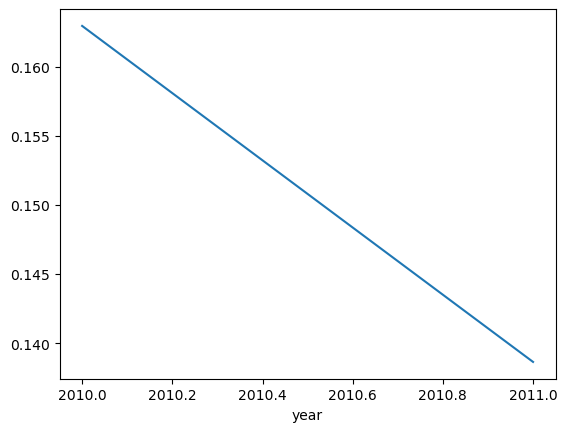

In [56]:
df_npmi_faction_env_bin[(df_npmi_faction_env_bin.topic=='env')&(df_npmi_faction_env_bin.fation=='Erakonna Eestimaa Rohelised fraktsioon')]\
.sort_values('year').set_index('year')['npmi'].plot()

<Axes: xlabel='year'>

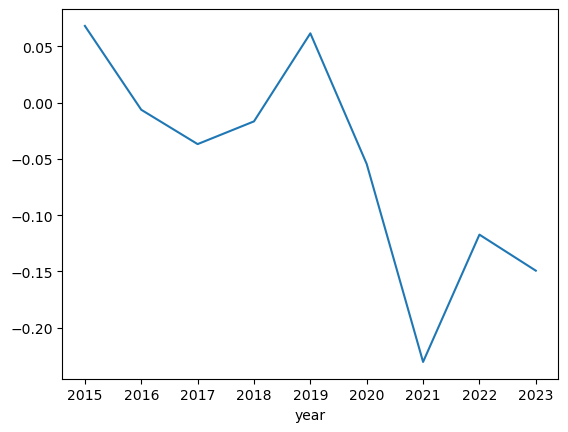

In [57]:
df_npmi_faction_env_bin[(df_npmi_faction_env_bin.topic=='env')&(df_npmi_faction_env_bin.fation=='Eesti Konservatiivse Rahvaerakonna fraktsioon')]\
.sort_values('year').set_index('year')['npmi'].plot()

<Axes: xlabel='year'>

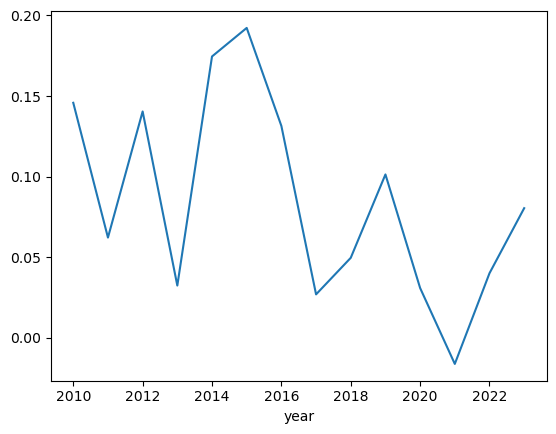

In [58]:
df_npmi_faction_env_bin[(df_npmi_faction_env_bin.topic=='env')&(df_npmi_faction_env_bin.fation=='Fraktsioonidesse mittekuulunud Riigikogu liikmed')]\
.sort_values('year').set_index('year')['npmi'].plot()

<Axes: xlabel='year'>

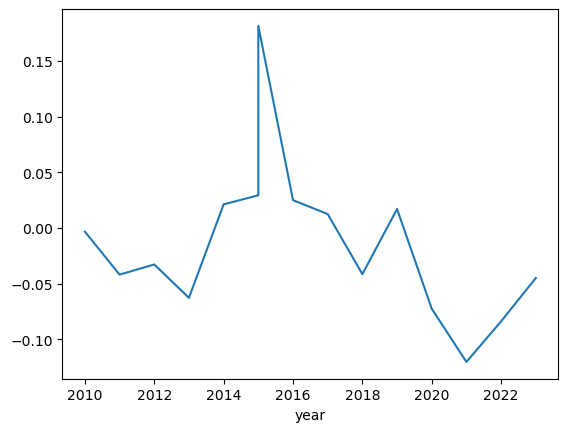

In [59]:
isamaa_factions=["Isamaa fraktsioon", "Isamaa ja Res Publica Liidu fraktsioon"]
df_npmi_faction_env_bin[(df_npmi_faction_env_bin.topic=='env')&(df_npmi_faction_env_bin.fation.isin(isamaa_factions))]\
.sort_values('year').set_index('year')['npmi'].plot()

<Axes: xlabel='year'>

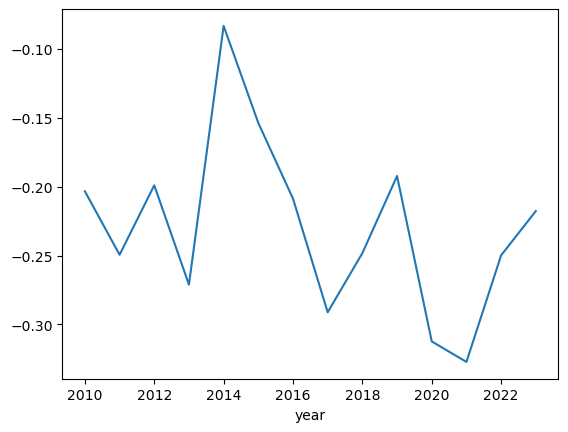

In [60]:
df_npmi_faction_env_bin[(df_npmi_faction_env_bin.topic=='env')&(df_npmi_faction_env_bin.fation=='no_faction')]\
.sort_values('year').set_index('year')['npmi'].plot()

## Speaker and environment topics NPMI

In [61]:
df_env_topic_speaker_pairs_count=calc_topic_other_pairs(df, topic_col='topic4analysis_env_bin',
                                                    other_col='speaker')

In [62]:
df_env_topic_speaker_pairs_count.head()

,speaker,topic,pair_count
0,<span>Aseesimees </span>Laine Randjärv,other,1
1,Kaitseminister Hanno Pevkur,env,1
2,Kaitseminister Jaak Aaviksoo,env,1
3,Tartu Ülikooli eesti keele võõrkeelena didakti...,other,1
4,Kaitseminister Margus Tsahkna,env,1


In [63]:
df_env_bin_count=pd.DataFrame(df.groupby(['topic4analysis_env_bin']).size())
df_env_bin_count.columns=['count']

In [64]:
df_env_topic_speaker_pairs_count=pairs2pmi(df_env_topic_speaker_pairs_count[['speaker', 'topic', 'pair_count']],
                                           df_env_bin_count, df_all_speakers_count,
                                      group1_name='topic', group2_name='speaker', pair_key_col2='speaker',
                                       pair_key_col1='topic')

In [65]:
df_env_topic_speaker_pairs_count.sort_values('npmi', ascending=False).head(20)

,speaker,topic,pair_count,p_pair,count_topic,count_speaker,p_topic,p_speaker,pmi,npmi
318,Valitsuse esindaja Kaire Karp,env,1,0.000002,11664,1,0.025057,0.000002,5.318628,0.282479
402,Asesimees Siim Kallas,env,1,0.000002,11664,1,0.025057,0.000002,5.318628,0.282479
159,Riigikogu juhatus,env,1,0.000002,11664,1,0.025057,0.000002,5.318628,0.282479
195,Reformierakonna fraktsioon,env,1,0.000002,11664,1,0.025057,0.000002,5.318628,0.282479
426,Aseeesimees Siim Kallas,env,1,0.000002,11664,1,0.025057,0.000002,5.318628,0.282479
14,Tanel Tein,env,1,0.000002,11664,1,0.025057,0.000002,5.318628,0.282479
940,Andrus Seeme,env,30,0.000064,11664,87,0.025057,0.000187,3.782575,0.271707
548,Mario Kadastik,env,3,0.000006,11664,5,0.025057,0.000011,4.581662,0.265705
1146,Arno Sild,env,75,0.000161,11664,376,0.025057,0.000808,2.992858,0.237536
829,Mari-Ann Kelam,env,17,0.000037,11664,64,0.025057,0.000137,3.406091,0.231063


## Save

In [66]:
df_env_topic_speaker_pairs_count.to_excel('data/interim/topics2022/env_topic_speaker_pairs_pmi.xlsx', index=False)

## Calculate all each year topic NPMI

In [67]:
df_all_top_year_npmi=pd.DataFrame()

for year in df.year.unique():
    topic_pairs_year = []
    print(year)
    df_=df[df.year==year]
    for topics in df_[(df_.topic4analysis!='-1')].groupby('index_pk').topic4analysis.unique():
        topics_ = list(set(topics))
        for i in range(len(topics_)-1):
            for j in range(i+1, len(topics_)):
                #keep sorting same always
                topic_pair=list(set([topics_[i], topics_[j]]))
                topic_i=topic_pair[0]
                topic_j=topic_pair[1]
                topic_pairs_year.append([topic_j, topic_i])
                
    df_topic_pairs_year_ = pd.DataFrame(data = topic_pairs_year, columns=['topic1', 'topic2'])
    df_topic_pairs_year_count_ = df_topic_pairs_year_.groupby(['topic1', 'topic2']).size()
    df_topic_pairs_year_count_ = df_topic_pairs_year_count_.sort_values().reset_index()
    df_topic_pairs_year_count_.columns=['topic1', 'topic2', 'pair_count']
    
    df_all_top_count_year_=pd.DataFrame(df_.groupby(['topic4analysis']).size())
    df_all_top_count_year_.columns=['count']
    df_topic_pairs_year_count_=pairs2pmi(df_topic_pairs_year_count_, df_all_top_count_year_)
    df_topic_pairs_year_count_['year']=year
    df_all_top_year_npmi=pd.concat([df_all_top_year_npmi, df_topic_pairs_year_count_])

2019
2021
2010
2015
2012
2017
2020
2011
2013
2016
2014
2018
2022
2023


In [68]:
df_all_top_year_npmi.shape

(509033, 11)

In [69]:
df_all_top_year_npmi.head()

,topic1,topic2,pair_count,p_pair,count_topic1,count_topic2,p_topic1,p_topic2,pmi,npmi,year
0,1002_ravimite_ravimiameti_hinnakokkuleppe_amr,1104_piirded_trollite_lendlehti_vestluse,1,0.000042,5,29,0.000211,0.001224,7.352447,0.505936,2019
1,360_järvik_järviku_mart_maaeluminister,2046_laen_laenu_laenukoormus_faktor,1,0.000042,80,11,0.003376,0.000464,4.750996,0.326925,2019
2,360_järvik_järviku_mart_maaeluminister,2045_pealkirjade_väitleme_debateerida_ajalehe,1,0.000042,80,12,0.003376,0.000506,4.625465,0.318287,2019
3,360_järvik_järviku_mart_maaeluminister,1980_täidesaatev_võim_võimude_võimukandja,1,0.000042,80,8,0.003376,0.000338,5.210428,0.358540,2019
4,360_järvik_järviku_mart_maaeluminister,1978_montaaživaht_džuudo_düstoopiat_prožektori,1,0.000042,80,2,0.003376,0.000084,7.210428,0.496164,2019


### Save

In [70]:
df_all_top_year_npmi.to_excel('data/interim/topics2022/topic_pairs_year_pmi.xlsx', index=False)